# Walkthrough of features created during summer project

This notebook has three principle aims:
1. To explain the scientific background and motivation behind the code written over the summer, and set the context for the result that you will be reproducing.
2. To highlight that the code written is in many ways system agnostic; it can be generalised to many different materials, interatomic potentials and fracture systems (i.e, if you were a potential researcher this code would be easy to adapt to your specific problem).
3. To provide the specific instructions needed to reproduce the result obtained from NCFlex.

The code provided is part of the matscipy package, and therefore is held to a high standard of documentation and has unit tests which serve to test it thoroughly.

## An introduction to fracture
Fracture is something that we as humans actually have a pretty intuitive grasp on. If you pull something brittle hard enough, it breaks, and (theoretically) if you were to push two clean surfaces of a broken material together, bonds should reform and it should heal. You can rationalise this using an energy argument - as you pull a material, what you're doing is storing elastic potential energy by stretching all of the atomic bonds a little. Growing a crack relieves this elastic energy - but at the cost of creating new surfaces, which are energetically unfavourable, so fracture will only occur when the crack growth can relieve enough energy to overcome this surface cost.

Why do we care about modelling fracture? Well, pretty simply, everything breaks, and pretty much all fracture modelling and prediction that exists today is either completely or semi-empirical. The aim of this work is to completely do away with using experimental data in fracture models (as fracture experiments are quite rough at the best of times) and instead build a bottom-up way to model fracture which derives its information directly from first-principles. In the future, the idea is that you could predict key fracture properties such as the crack initation stress and crack path selection completely from a model without having to do any experiment at all - thus saving a huge amount of money (as fracture testing is expensive!).

We can seperate fracture out into two main regimes. These are:
1. Slow fracture, which occurs in a material very close to its breaking point, which has not yet critically failed. This is similar concept to diffusion - the crack advances by 'jumping over' energy barriers, using energy from thermal excitations in the material, and progesses very slowly. This notebook is focused on this regime.

2. Fast (or dynamic) fracture, which occurs when a material is pulled to stress intensity above its fracture toughness. In this case, crack motion is very fast (usually a large fraction of the speed of sound in the material). You will be doing some dynamic fracture simulations in LAMMPS to attempt to reproduce the fracture toughness found from this notebook. (Don't worry - nearly all the code is provided).

## Difficulties with modelling atomistic fracture
Modelling atomistic fracture well is really, really difficult. These difficulties can essentially be broken up into two categories - those that are interatomic potential related and those that are boundary conditions related.

### Inter-atomic potential problems
At the very tip of a crack in a brittle material, bonds are breaking, which is a fairly extreme environment for atoms to be in. To get accurate forces between atoms, you need either a highly specialised inter-atomic potential, or a first principles method like density functional theory (DFT). For many years, inter-atomic potentials simply weren't good enough, meaning that the most successful method for modelling fracture was Quantum-Mechanics/Molecular-Mechanics or QM/MM, which is a method where an inner region around the crack tip is described using ab-initio molecular dynamics with DFT, and this is coupled through a boundary to a much larger number of atoms which are described using a cheap interatomic potential. Whilst this method was certainly successful, it was limited to very short timescales by the intense cost of computing an ab-initio calcuation every timestep. 

Recently however, the development of machine learned interatomic potentials such as the atomic cluster expansion (ACE) type potentials have revolutionised the field of atomic modelling, including fracture, as they are capable of an accurate description of the bond breaking process whilst being cheap enough for much longer time and length scale simulations. Detailed information about these are outside the remit of this notebook, but all simulations being done today will use a carbon ACE potential, which has been shown to be good at describing both the bond breaking and surface reconstruction processes necessary for describing fracture accurately [1].

### Boundary condition problems
When we model an atomistic domain, we'd like to be modelling it as if it were small part of a much larger structure, to reflect a relevant real life situation. This requires *flexible boundary conditions* which essentially allows the boundary to update as the crack moves, mimicing being a cut-out of a much larger system. However, before now, the majority of fracture simulations used *static boundary conditions* which essentially can be thought of as considering the entire fracture system to be the size of the modelled atomistic domain - on the order of just a few nm. As you can imagine, fracture in a nano-particle is not reflective of fracture in a large body, so the results from these static boundary condition simulations are inaccurate.

To model flexible boundary conditions, we essentially make an assumption, which is that past some radial distance away from the crack tip in our atomistic domain, the displacement of atoms follows that predicted from the continuum solution around a crack tip. Then, as the crack moves, we update the positions of these boundary atoms according to the continuum solution with the new updated crack tip position as the origin.

A lot of the work done this summer was to ensure that this approximation holds - that is, that the displacements of atoms around a crack tip tend to the continuum solution sufficiently quickly for flexible boundary conditions to work and provide good results. This work will be highlighted here, and there are essentially two parts. The first part is all about something called the Cauchy-Born shift corrector in multi-lattices, which is relevant for diamond. The second part is about surface relaxation. 

### Cauchy-Born corrector shift in multi-lattices
Diamond is a multi-lattice. Which means that it's a non-Bravais lattice, as it has two atoms in it's primitive unit cell. You can essentially think of the diamond structure as two inter-penetrating FCC lattices, which we'll call 'sublattices'. Remember a second ago when I said that flexible boundary conditions only work when 'the atomic displacements tend to the continuum solution' - well that doesn't actually work in multi-lattices. For Bravais lattices, mapping a contiuum displacement field to some atoms is totally easy - you just displace the atoms pretending they're points in a continuous space deforming according to the continuum solution (this is the 'Cauchy-Born approximation'). However, for multi-lattices, if you do this, you find that the atoms have high forces on them. This is because there is an extra degree of freedom that exists between sublattices - one sublattice can move relative to the other - which simply can not be known from the continuum solution, and has to be found by relaxing the atoms under the influence of an interatomic potential. 

Uh oh! This is a BIG problem. The whole point of flexible boundary conditions is that we can pretend we are modelling a small part of a much larger domain - but if in order to actually displace atoms according to the continuum solution at the boundary we have to relax every atom, it makes the method essentially useless. So, how do we fix this? Well, we need some way to predict the difference between the true atomic positions and the Cauchy-Born approximation predicted positions. This difference is called the Cauchy-Born corrector shift.

This was implemented in matscipy through the use of a regression model. We first need to fit the model to be able to predict the Cauchy-Born predictor shifts, and then we can test it. This section is a walk through of how you can interface with code that I've written to do this for a simple case.

In [1]:
#import modules and set up calculator
import numpy as np
from ase.build import bulk
from ase.lattice.cubic import Diamond
from ase.optimize.precon import PreconLBFGS
from ase.constraints import ExpCellFilter
from matscipy.cauchy_born import CubicCauchyBorn
from ase.calculators.lammpslib import LAMMPSlib
from ase.optimize import LBFGS

#set up calculator
cmds = ['pair_style hybrid/overlay pace table spline 10000',
        'pair_coeff * * pace c_v3.yace C', 'pair_coeff * * table d2.table D2 9.0']
calc = LAMMPSlib(amendments=["mass 1 12.101"],lmpcmds = cmds,log_file='test.log',keep_alive=True)

#find eq lattice constant
el              = 'C'
a0_init         = 3.56
print('optimising lattice parameter')
unit_cell = Diamond(size=[1,1,1],symbol=el,latticeconstant=a0_init,pbc=(1,1,1))
unit_cell.set_calculator(calc)
ecf = ExpCellFilter(unit_cell)
uc_optimise = LBFGS(ecf)
uc_optimise.run(fmax=0.0001)
a0 = unit_cell.get_cell()[0,0] #get the optimised lattice parameter
print('optimised lattice parameter:',a0)

optimising lattice parameter
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 16:00:27      -73.005280*       0.6081
LBFGS:    1 16:00:27      -72.979340*       2.5741
LBFGS:    2 16:00:27      -73.006763*       0.0115
LBFGS:    3 16:00:27      -73.006764*       0.0002
LBFGS:    4 16:00:27      -73.006764*       0.0000
optimised lattice parameter: 3.5658038209718814


In [2]:
#define a function which we can use to impart a strain field to a set of atoms
def E_cart3D(x, y, z, eps=None):
    #Here, this function is extremely simple, it just takes a strain vector (eps) and converts it into a set of
    #matrices, which are the same for each atom (as the applied strain is uniform).
    #In more general use, for example within the fracture code,
    #this function would take a set of atomic positions (x,y,z) and evaluate the continuum strain field
    #at those points, and return the strain state in matrix form for each atom.
    E = np.zeros([len(x), 3, 3])
    E[:, 0, 0] = eps[0]
    E[:, 1, 1] = eps[1]
    E[:, 2, 2] = eps[2]
    E[:, 1, 2], E[:, 2, 1] = eps[3], eps[3]
    E[:, 0, 2], E[:, 2, 0] = eps[4], eps[4]
    E[:, 0, 1], E[:, 1, 0] = eps[5], eps[5]
    return E

#define a function which can be used to test a fitted regression model
def model_prediction(dirs, eps, method, cb, E_func, coordinates='cart3D', atol=1.5e-5):
    #this function allows us to evaluate the true shift and predicted shift for a single strain vector, in
    #order to compare how good the regression model is
    
    #create the rotation matrix from the specified directions
    A = np.zeros([3, 3])
    for i, direction in enumerate(dirs):
        direction = np.array(direction)
        direction = (1/np.linalg.norm(direction))*direction
        A[:, i] = direction

    # generate rotated unitcell (according to dirs)
    atoms = Diamond(cb.el, latticeconstant=cb.a0,
                    size=[1, 1, 1], directions=dirs)
    atoms.set_pbc([True, True, True])
    atoms.calc = calc
    atoms_copy = atoms.copy()
    cb.set_sublattices(atoms, A)
    
    #get the true cauchy-born corrector shift
    shift_diff_true = cb.eval_shift(
        eps, atoms)
    #get the model predicted shift
    shifts = cb.predict_shifts(
        A, atoms, E_func=E_func, eps=eps, method=method, coordinates=coordinates)
    shift_diff_predicted = shifts[0, :]
    
    return shift_diff_true,shift_diff_predicted

Now we've defined some functions we can use to apply a continuum strain field to a single diamond unit cell, and then measure the true Cauchy-Born corrector shift and compare it to our model prediction. It's now time to initialise and fit our model, which is done simply by creating a CubicCauchyBorn object from the matscipy package, which was created and is maintained by me - if you'd like to have a look at the code and documentation, please see https://github.com/libAtoms/matscipy/blob/master/matscipy/cauchy_born.py

In [3]:
#Initialise the Cauchy-Born shift corrector object
cb = CubicCauchyBorn(el, a0, calc, lattice=Diamond)

#Fit the Cauchy-Born corrector model
cb.initial_regression_fit()

#Now, test how good it is at predicting the cauchy-born shift correctors for
#shear strains between -0.02 and 0.02, which is a reasonable range for fracture,
#for a rotated diamond unit cell
dirs = [[1, 1, 0], [-1, 1, 0], np.cross([1, 1, 0], [-1, 1, 0])]
eps_vals = np.linspace(-0.02,0.02,100)
true_shifts = np.zeros([len(eps_vals),3])
predicted_shifts = np.zeros([len(eps_vals),3])

for i,eps in enumerate(eps_vals):
    eps_vec = [0,0,0,eps,-eps,eps]
    true_shift, predicted_shift = model_prediction(dirs, eps_vec, 'regression', cb, E_cart3D)
    #print(true_shift,predicted_shift)
    true_shifts[i,:] = true_shift
    predicted_shifts[i,:] = predicted_shift

Performing initial regression fit for CB corrector.....
Fit completed


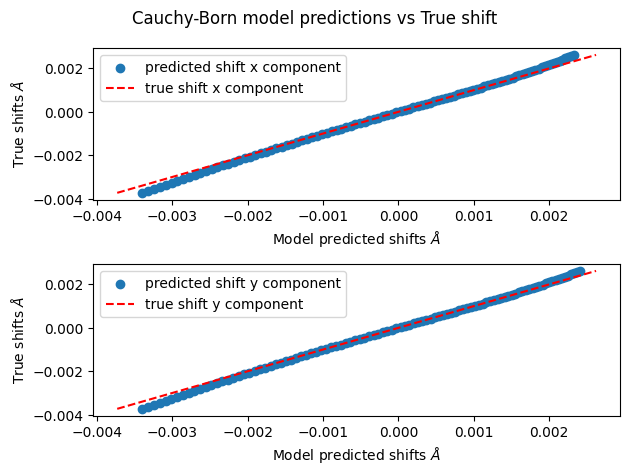

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,axs = plt.subplots(2,1)
fig.suptitle('Cauchy-Born model predictions vs True shift')
axs[0].scatter(predicted_shifts[:,0],true_shifts[:,0],label='predicted shift x component')
axs[0].plot(true_shifts[:,0],true_shifts[:,0],'r--',label='true shift x component')
axs[0].set_xlabel(r'Model predicted shifts $\AA$')
axs[0].set_ylabel(r'True shifts $\AA$')
axs[0].legend()
axs[1].scatter(predicted_shifts[:,1],true_shifts[:,1],label='predicted shift y component')
axs[1].plot(true_shifts[:,1],true_shifts[:,1],'r--',label='true shift y component')
axs[1].set_xlabel(r'Model predicted shifts $\AA$')
axs[1].set_ylabel(r'True shifts $\AA$')
axs[1].legend()
fig.set_tight_layout(True)



As you can see, the model predictions are remarkably good - and match the true shifts very well, particularly for small shifts. In the context of fracture, this allows for a much faster rate of force decay as we move away from the tip of a crack, allowing our simulations to converge, when previously they would not. The fact that the model shows deviation at large shifts also is not really a problem - this is because the region near the crack tip is relaxed explicitly, and we only need this model to work well in the far field where strains are very small anyway. There are some figures showing this increased rate of decay in my report.

### Surface reconstruction in fracture

A major violation of the approximation mentioned above - that forces around the tip of a crack decay to 0 as they approach the boundary - are the two surfaces formed by fracture. As surface relaxation is highly non-linear, the continuum solution is unable to describe them even close to correctly, leading to giant forces that do not decay with distance from the crack tip. To solve this problem, code was written which was able to essentially map out the surface relaxation in a small unit cell of exposed surface in the crystal, and 'paste' this relaxation onto the exposed surfaces directly. This greatly reduced the surface forces. Functionally, this code is very easy to use - let's look at an example.

In [10]:
from ase.visualize import view
#First, let's make a large supercell of a structure and view it
surf_dir = 1
size = [10,20,10]
directions = [[1, 1, 0], [-1, 1, 0], [0, 0, 1]]

#create the rotation matrix from the specified directions
A = np.zeros([3, 3])
for i, direction in enumerate(dirs):
    direction = np.array(direction)
    direction = (1/np.linalg.norm(direction))*direction
    A[:, i] = direction

shift_vec = np.zeros([3])
shift_vec[surf_dir] += 0.01

bulk = Diamond(directions=directions, size=size,
               symbol=el, latticeconstant=a0, pbc=(1, 1, 1))

#as this is a multilattice - we need to determine the sublattices. We can do this using a cauchy_born object
cb.set_sublattices(bulk,A)

bulk.positions += 0.01
bulk.wrap()



cell = bulk.get_cell()
cell[surf_dir, :] *= 2  # vacuum along surface axis (surface normal)
slab = bulk.copy()
slab.set_cell(cell, scale_atoms=False)
pos = slab.get_positions()

sorted_surf_indices = np.argsort(pos[:, surf_dir])

# apply the surface reconstruction to the top surface only
surface_atom = np.argmax(pos[:, surf_dir])
surface_coords = pos[surface_atom, :]+np.array([0.01, 0.01, 0.01])
slab.set_calculator(calc)
initial_force = slab.get_forces()
slab_before = slab.copy()
view(slab, viewer='ngl')

We can have a look at the surface forces in this big slab before a relaxation is mapped and applied. As you will see, the surface force is high.

In [11]:
#print initial large max surface force
natoms = len(slab)
maxfbefore = np.max(
    np.abs(initial_force[sorted_surf_indices[int(natoms/2):natoms]]))
print(f'max force before {maxfbefore}')

max force before 4.414600202281976


Now, let's map out the reconstruction by calling the 'map_surface' function from the SurfaceReconstruction object. This object is also part of matscipy, and was created by me - please feel free to look at the code and documentation here: https://github.com/libAtoms/matscipy/blob/master/matscipy/surface_reconstruction.py

In [12]:
from matscipy.surface_reconstruction import SurfaceReconstruction
#Now, map the surface shift in a single unit cell very cheaply
sr = SurfaceReconstruction(
                    el, a0, calc, dirs, surf_dir, lattice=Diamond, multilattice=True)
sr.map_surface(fmax=0.0005, shift=0)

PreconLBFGS:   0  16:02:17     -357.027432       4.5539
PreconLBFGS:   1  16:02:17     -357.393159       3.5087
PreconLBFGS:   2  16:02:17     -357.499978       2.4410
PreconLBFGS:   3  16:02:17     -357.549429       2.8353
PreconLBFGS:   4  16:02:17     -357.617982       2.4494
PreconLBFGS:   5  16:02:17     -357.701595       1.3530
PreconLBFGS:   6  16:02:17     -357.738395       0.9105
PreconLBFGS:   7  16:02:17     -357.754389       0.6444
PreconLBFGS:   8  16:02:17     -357.762584       0.4998
PreconLBFGS:   9  16:02:17     -357.766682       0.4825
PreconLBFGS:  10  16:02:17     -357.769579       0.4162
PreconLBFGS:  11  16:02:17     -357.772927       0.3178
PreconLBFGS:  12  16:02:17     -357.777014       0.2187
PreconLBFGS:  13  16:02:17     -357.780417       0.1810
PreconLBFGS:  14  16:02:17     -357.781655       0.1100
PreconLBFGS:  15  16:02:17     -357.782011       0.1043
PreconLBFGS:  16  16:02:17     -357.782481       0.0744
PreconLBFGS:  17  16:02:17     -357.783024      

Now, we can just map this single surface unitcell reconstruction directly onto a larger surface. You will see that after mapping, the forces after have gone down

In [13]:
#Now apply this shift to the surface, and visualise it again
sr.apply_surface_shift(slab, surface_coords, cb=cb, xlim=None,
                       ylim=None, zlim=None, search_dir=-1, atoms_for_cb=bulk)

In [14]:
final_force = slab.get_forces()
view([slab_before,slab], viewer='ngl')
#Use the slider to look at the structures before and after the surface reconstruction is mapped!

In [15]:
#Get the final force and show it's much lower
natoms = len(slab)
maxfafter = np.max(
    np.abs(final_force[sorted_surf_indices[int(natoms/2):natoms]]))
print(f'max force after {maxfafter}')

max force after 0.00313143039105717


Clearly, the surface force is now much lower - and we've not had to relax anything except from a small unit cell of surface, meaning the computational cost is very cheap; much cheaper than relaxing the full surface. This code is fully general for any 1x1 reconstruction in any material, and is also implemented in matscipy for specific cases for symmetry breaking reconstructions including the 2x1 Pandey diamond 111 reconstruction, and the silicon 110 3x1 reconstruction.

# A full NCFlex simulation and fracture toughness

The details of how NCFlex works are covered in the report - but in brief, you can think of it as a way to explore the domain where slow (non dynamic) fracture is possible. Before we go any further, we need to define the stress intensity factor $K$. You can think of $K$ as describing how an applied far field stress at the boundary of a material far from the crack is amplifed by the geometry of a given crack. Dynamic fracture occurs when $K$ reaches a value $K_{+}$ which is a material dependent constant, called the fracture toughness. We can find this using NCFlex by finding the largest stable $K$ value allowed in the regime where slow fracture is possible. Running a full NCFlex simulation is straightforward but time consuming and often requires a few hours. I'm very aware that you'd rather be doing something else right now, so here we'll just load a figure from previous calculations that were done.

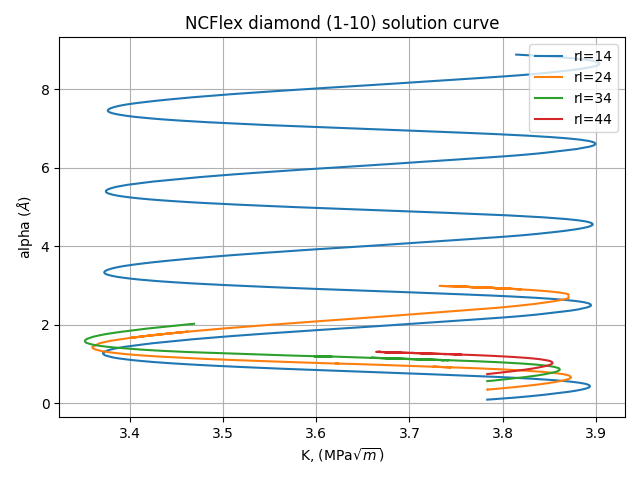

In [18]:
from IPython.display import Image
Image(filename="NCFlex_figure.png")

The different curves here represent different region I radii used in NCFlex. The idea is that the greater the region I radius, the less the finite size effect and subsequently the more accurate the simulation is, but the more expensive. From this curve, the maximum value of $K$ that the crack can be stable for ($K_{+}$) is 3.83$\pm$0.03 MPa$\sqrt{\mathrm{m}}$.

# Reproducing this result

Now it's your turn! It's time to reproduce this result by looking at dynamic fracture. Essentially, what I'd like you to do is run a number (~5) of dynamic fracture simulations where you apply a set value of $K$ and measure the crack speed, and then plot a graph of crack speed vs $K$. What you should see is that once $K$ is larger than approximately $K_{+}$, the crack speed should massively increase. Ideally, by taking a few measurements, you should be able to pinpoint a rough value of $K$ where this occurs, and this should line up with the predicted value of $K_{+}$ presented here. 

The simulation you'll be running will be a 'thin-strip' type fracture configuration and it'll be at finite temperature. This means that the $K_{+}$ you'll measure will be slightly lower than that predicted here for 0 Kelvin - this is caused by a mixture of different boundary conditions and the fact that at finite temperature, you have to pull slightly less hard to overcome the energy barrier for fracture.

I've written all the code to do this for you already. On 40 cores, each of the runs should take you ~5 minutes.

# Detailed instructions for running the LAMMPS MD simulations

In the folder this notebook is present in, there should be a seperate folder named LAMMPS_investigation. In your IDE of choice, navigate to this folder and open the python file params.py. This is the file which provides the information to set up the crack geometry for the MD. At the top of this file, there is an area where you can change the value of K to be supplied to the simulation. I'd like you to test the following values of K:

K values to test:
3.75, 3.78, 3.81, 3.84, 3.87

Once you've put in a value of K, save the params.py file. Now open the run_simulation.sh script. In this script, adjust the number of processors you'd like to use to run the MD. Once that's done, save the script and make it runable with 
```
chmod u+x run_script.sh
```
and then run 
```
./run_script.sh
```
After about 5 minutes (on 40 cores), the last lines printed to terminal at the end of the simulation will be the crack speed. Record this for the value of K you put in, and then re-run the simulation for each value of K above. Plot a graph of crack speed against K - it should look like a line that fluctuates around 0 and then steeply jumps up once $K$>$K_{+}$. If you'd like to see what the MD is doing, run the box below in this notebook, and move the slider to see the crack grow. 

For the result (and it's error), look at the two $K$ values you've taken either side of the point where the crack speed jumps up. These will be your error bounds for $K_{+}$, with the actual $K_{+}$ value being the average of these values. In this case this is a good way to estimate error as one of the side effects of introducing finite temperature is a 'smearing effect' - at 0K, $K_{+}$ is a sharp transition from stationary to fast crack, but at finite temperature this transition is more gradual. If you'd like, feel free to take more measurements to try and refine your guess for $K_{+}$. The final value should be a little lower than the result found from NCFlex above, probably around 3.78 MPa$\sqrt{\mathrm{m}}$. This is because of epistemic uncertainty associated with the difference in boundary conditions and finite temperature.

In [57]:
#USE THIS BOX TO VISUALISE THE OUTPUT OF AN MD TRAJECTORY
import ase
traj = ase.io.read('LAMMPS_investigation/dump.lammpstrj',index=':')
for t in traj:
    t.symbols = 'C23040'
view(traj, viewer='ngl')

### References
[1] J. Chem. Theory Comput. 2023, 19, 15, 5151–5167